**_pySpark Basics: Graphing_**

_by Jeff Levy (jlevy@urban.org)_

_Last Updated: 1 Aug 2016, Spark v1.6.1_

_**Abstract:** Spark does not currently have its own graphing abilities, so in this tutorial we will go over several Python options for working with aggregated or subsetted data._

_**Main operations used:** Matplotlib, Pandas, collect, toPandas_

***

Dealing with very large data forces us to divide options for plotting into two categories: those that involve an aggregation step first, and those that don't.

There are many ways to **aggregate data for plots** (e.g. hexbins, box plots, bar graphs), and when your data is big one beneficial side effect is that aggregating reduces the size.  If the aggregation is enough to allow your data to be loaded into memory then there is no problem; you can use whatever plotting tools you like.  You can download your data to an S3 bucket, or locally to your computer, and make your plots that way.  You can also use the tools Python provides for plotting, which we will go into here.  Even if you're more comfortable with a different program (e.g. Excel, Stata, SAS, Gnuplot, Matlab), you may want to continue in Python rather than downloading since it allows you to generate the graphs in the same platform you use to work with the larger dataset.

**Plotting big data without aggregating**, for example in a bivariate scatter plot, gets difficult as your data gets larger.  There are two possible solutions: first, it may be possible to use Amazon Web Services to spin up a single machine with a large amount of memory to work on, for the sole purpose of creating the graph.  The machine itself is likely to be expensive to access, but that may be offset by only needing it very briefly.  There is not currently a system in place for this to happen.  The second option is still untested in Spark, and that is to use the Bokeh DataShader module for Python.  Whether this works in a distributed environment will be the subject of future work.

In [1]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Loading and Viewing the Data

For this example we will use a dataset on diamond attributes and prices.  This is the same data used in the ggplot tutorial for plotting in R.  After we load it we'll take a quick look at what it contains.

In [3]:
spark_df = sqlContext.read.load('s3://ui-spark-data/diamonds.csv',
                          format='com.databricks.spark.csv',
                          header='true',
                          inferSchema='true',
                          delimiter=',')

In [4]:
spark_df.show(5)

+-----+-------+-----+-------+-----+-----+-----+----+----+----+
|carat|    cut|color|clarity|depth|table|price|   x|   y|   z|
+-----+-------+-----+-------+-----+-----+-----+----+----+----+
| 0.23|  Ideal|    E|    SI2| 61.5| 55.0|  326|3.95|3.98|2.43|
| 0.21|Premium|    E|    SI1| 59.8| 61.0|  326|3.89|3.84|2.31|
| 0.23|   Good|    E|    VS1| 56.9| 65.0|  327|4.05|4.07|2.31|
| 0.29|Premium|    I|    VS2| 62.4| 58.0|  334| 4.2|4.23|2.63|
| 0.31|   Good|    J|    SI2| 63.3| 58.0|  335|4.34|4.35|2.75|
+-----+-------+-----+-------+-----+-----+-----+----+----+----+
only showing top 5 rows



In [5]:
spark_df.describe(['carat', 'depth', 'table', 'price']).show()

+-------+------------------+------------------+------------------+-----------------+
|summary|             carat|             depth|             table|            price|
+-------+------------------+------------------+------------------+-----------------+
|  count|             53940|             53940|             53940|            53940|
|   mean|0.7979397478679879|61.749404894327284| 57.45718390804599|3932.799721913237|
| stddev|0.4740112444054211|1.4326213188336516|2.2344905628213168|3989.439738146379|
|    min|               0.2|              43.0|              43.0|              326|
|    max|              5.01|              79.0|              95.0|            18823|
+-------+------------------+------------------+------------------+-----------------+



If necessary we could first subset the data to make it small enough to handle with standard tools, for example by dropping certain columns, taking a random sampling, and so on (see the `subsetting` tutorial).

# Using Matplotlib

There are many graphing solutions in Python, but the most common one by far is Matplotlib.  It is very flexible; literally every aspect of a graph can be manipulated and fine-tuned if desired.  This can make it a great tool, but that same flexibility often leads to complex and verbose code.  We will start with a very simple example that uses only a bare minimum of the things Matplotlib can do, and let it otherwise fill in default settings for us.

Remember, in order to graph in Matplotlib our data cannot be distributed; it must be small enough to be collected.  Therefore, we begin by extracting the values of the two columns we want to plot directly from the Spark dataframe:

In [6]:
carat = spark_df[['carat']].collect()
price = spark_df[['price']].collect()

Using `collect` has technically loaded into memory two lists of row objects that only have one entry each (`carat` in one and `price` in the other).  We could convert these to plain Python lists if we wanted, but Matplotlib knows how to work with these, so there's no need.  Take a look at the first five entries of each, to get an idea:

In [7]:
print(carat[:5])
print(price[:5])

[Row(carat=0.23), Row(carat=0.21), Row(carat=0.23), Row(carat=0.29), Row(carat=0.31)]
[Row(price=326), Row(price=326), Row(price=327), Row(price=334), Row(price=335)]


Matplotlib leverages the object-oriented nature of Python by creating objects that we then manipulate properties for.  To start, we first define a **figure object**, named `fig`, then create one or more **subplots** inside of the figure by defining an **axis object**, named `ax`, that points to the single subplot in our figure.

Each figure can have one or more subplots within it, arranged according to the `fig.add_subplot(a,b,c)` line below.  Here, `'a'` defines how many rows (of plots) your figure has, `'b'` defines how many columns, and `'c'` defines which plot within the figure the axis object points to.  By passing `'1,1,1'` as we do below, we tell it the figure has 1 row, 1 column, and that we want to work with the 1st (and in this case only) subplot out of those:

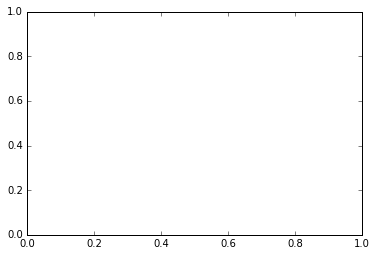

In [8]:
fig = plt.figure()           #an empty figure
ax = fig.add_subplot(1,1,1)  #a single subplot within the figure

Which as you can see is currently an empty figure, because we haven't given it any data or settings.  Note that each time a figure is displayed or saved, Matplotlib clears the queue and we need to define it again.

If we wanted, say, four different plots to show up, one in each corner of the figure, we would create four subplots, each with its own axis pointer, and tell it to have 2 rows, 2 columns, and then number the plots 1-4.  We could then set attributes on the entire figure by modifying properties of `fig`, or on each individual plot by modifying attributes on `ax1`, `ax2`, `ax3`, or `ax4`:

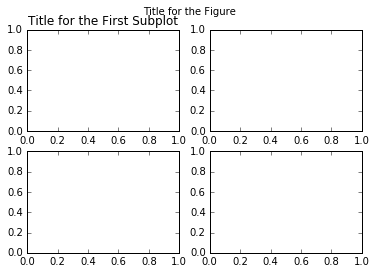

In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

fig.suptitle('Title for the Figure')
ax1.set_title('Title for the First Subplot')

There is an enormous number of figure and axis methods that can be used.  You can see above that we added a title to the figure and a title to one subplot, just as simple examples, though we won't go into very many of the others that can be done in this tutorial.  

To give some data to our graph we'll use the `plot` method on an axis, followed by adding a few labels.  By passing it as the first argument of `plot()`, we put `carat` on the x-axis and then the second argument, `price` on the y-axis.

The third argument, `'go'`, is a format string that has two components; **the first letter is the color, the second is the marker style.**  In this case, the `g` is for green and the `o` is for dots.  There are many more.  For a few example combinations, `'b--'` would be blue with a solid line connecting them, `'r-'` would be red with a dashed line, `'k^'` is black triangles, and `'ys'` is yellow squares.

The `alpha` argument sets the level of transparency - it can be interpreted as the number of overlapping observations necessary to achieve the maximum opacity value of 1.  For the value `alpha=0.1` then, ten overlaps will equal full color.

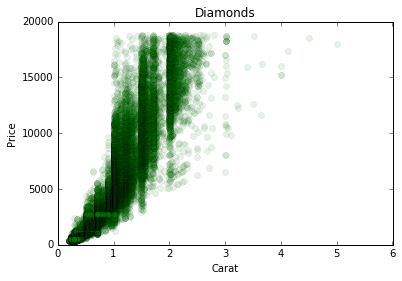

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(carat, price, 'go', alpha=0.1)
ax.set_xlabel('Carat')
ax.set_ylabel('Price')
ax.set_title('Diamonds')

# Using Pandas

Plotting in Python can be simplified if you first turn your Spark dataframe into a **Pandas** dataframe.  In addition to Pandas convenient plotting tools, this also gives you access to many other dataframe manipulations similar to the R language.  Note once again that you can only use Panads on datasets small enough to fit on one system; like native R dataframes, they do not support a distributed environment.  Therefore you may need to subset a large distributed Spark dataframe before it can be loaded and worked with this way.  As with Matplotlib, Pandas can easily handle our diamonds dataset however.

**R, Pandas, pySpark and SparkR all share a lineage**, and while there are differences that can trip you up when going between them there are also a lot of similarities that you will hopefully recognize.

**Spark dataframes have a built-in method to turn themselves into Pandas dataframes:**

In [11]:
pandas_df = spark_df.toPandas()
pandas_df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


**What does the relationship between `clarity` and `price` look like?**  We'll use a bar graph to take a look.  First we group the Pandas dataframe by `clarity`, then we ask it to aggregate `price` by its `mean`.  

Note that we add `reset_index` to the end because we need to treat `clarity` as a column, not an index, and Pandas by default makes the groupby category an index.  PySpark dataframes do not have indicies, but Pandas dataframes cannot be without them; when we tell `clarity` to be a column again instead of an index Pandas just fills in an index of integers from 0 on up by default.  

In [12]:
grouped = pandas_df.groupby('clarity').agg({'price':'mean'}).reset_index()

If we were **aggregating multiple columns by different operations** we could simply pass more entries into the dictionary for `agg()`, e.g.:

    .agg({'price:'mean', 'table':'min', 'depth':'max'})

Or if we were applying **the same aggregation operation to all columns**, then replacing `.agg(...)` with `.mean()` would be syntactic sugar for:

    .agg({'carat':'mean', 'depth':'mean', 'table':'mean', 'price':'mean', 'x':'mean', 'y':'mean', 'z':'mean'})

I won't go into a line-by-line breakdown of this next code block, but suffice to say it's all to force the x-axis of our bar graph into the order we specify in `clarity_order`.  We know that diamond clarity ratings do have a cardinal ordering, but there is nothing in the dataset to tell us this automatically so we have to define it.  This wouldn't be necessary if there was a clear way to sort the columns, for example by alphabetical or numerical order, or if we didn't want them sorted.

In [13]:
#in order from greatest clarity to least:
clarity_order = ['FL', 'IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1', 'I2', 'I3']
mapping = {day: i for i, day in enumerate(clarity_order)}
key = grouped['clarity'].map(mapping)
grouped = grouped.iloc[key.argsort()]

Once our data is ready we just use the convient `plot` method that Pandas dataframes have:

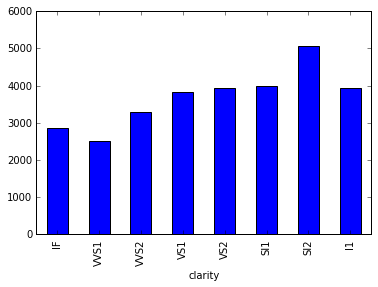

In [14]:
grouped.plot(kind='bar', x='clarity', legend=False)

# Pandas and Matplotlib Together

If the default formatting of the Pandas graph looks a lot like the Matplotlib graph we created earlier, it should; Pandas plotting is built on Matplotlib.  It just handles a lot of the more verbose parts of Matplotlib in the background for us.

In fact we can even use them together, if we want the convenience of Pandas automatic plotting with the ability to alter every last detail that Matplotlib provides.  First we use the Pandas `plot` method to *assign an axis object* (`ax`), rather than calling it without assigning it to anything as we did above.

Pandas will then handle all the default formatting of the axis for us, allowing us to override whatever features we want afterword.  In this case we set the labels and titles; you can see it's otherwise the same graph as above.

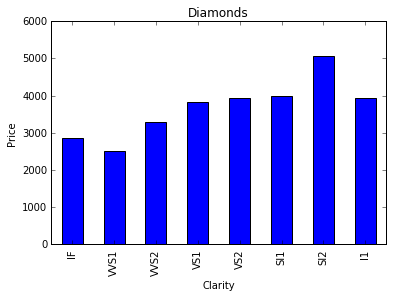

In [15]:
#same line as in the previous code block, only beginning with `ax = `
ax = grouped.plot(kind='bar', x='clarity', legend=False)

#then we set some options using Matplotlib commands
ax.set_xlabel('Clarity')
ax.set_ylabel('Price')
ax.set_title('Diamonds')

# Misc

Jupyter notebooks automatically display our figure for us when a codeblock that creates one is executed; this is a convenience that is due to the `%matplotlib inline` "magic" function that we called at the top of the notebook.  Normally after our figure is ready we must call `plt.show()` to see the graph.

Along these lines, if we want to save a figure we can call `plt.savefig(<path to an S3 bucket>)` once it's created.  It is also possible to right-click on an image once Jupyter displays it and save it locally to your computer, though if you're creating many graphs for example inside of a loop, this may not be practical.

A few references for making your Matplotlib graphs even nicer:

   **Text on Matplotlib graphs:** http://matplotlib.org/users/text_intro.html
   
   **Creating beautiful graphs:** http://www.randalolson.com/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/